In [1]:
import math
import numpy as np
from scipy import integrate
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import concurrent.futures
import os
import pickle

%matplotlib inline
tau = 2 * math.pi
pi = math.pi
random.seed(666)

import profiles as P

with open("naca0012.dat", "r") as f:
    x, y = np.loadtxt(f, dtype = float, delimiter="\t", unpack = True)

freestream_4 = P.Freestream(u_inf = 1, alpha = 4)

NACA0012 = P.Profile(x,y)
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()

In [2]:
with (open("gen1", "rb")) as pkl:
    gen1 = pickle.load(pkl)

In [3]:
def penalty_function(profile):
    if profile.roughness < 2:
        return profile.roughness
    else:
        return (profile.roughness-2)**2

CL_NACA0012 = NACA0012.cl
shadow_NACA0012 = NACA0012.shadow
r = 0.1

def general_objective_function(profile,  A: callable, B: callable):
    fitness = A(profile.cl / CL_NACA0012) / B(profile.shadow / shadow_NACA0012) - r * penalty_function(profile)
    if fitness > 0:
        return fitness
    else:
        return 0
    
def objective_function_0(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x)
    
def objective_function_shadow_squared(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x**2)
    
def objective_function_shadow_tangens(profile):
    return general_objective_function(profile, lambda x: x, lambda x: np.tan)

def objective_function_shadow_power3(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x**3)

In [4]:
def mutate(p, mu_range = [0, 1], d_range = [-4, 4]):
    """
    mutates a given profile by denting
    mu - allowed range of dent's centre
    d - amplitude for the dent, scaled by NACA0012's vertical shadow
    """
    mu = random.uniform(mu_range[0], mu_range[1])
    d = random.uniform(d_range[0], d_range[1]) * shadow_NACA0012
    p.dent(mu, d)
    p.get_aero(freestream_4)
    p.get_limitations()
    
def chance_mutate(p, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5):
    """
    has a prob probability of mutating profile p. default prob = 1/2
    """
    if random.uniform(0, 1) < prob:
        mutate(p, mu_range, d_range)
    print(f"mutated {p.ID}")
    
def make_children(P, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 10):
    def fun(P):
        return chance_mutate(P, mu_range = mu_range, d_range = d_range, prob = prob)
    children = []
    for i in range(n):
        children.append(P.copy())
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children) 
    print(f"***Finished children of {P.ID}***")
    return children

In [5]:
def roulette_wheel_selection(profiles):
    """
    returns ID of profile winning roulette wheel selection out of the given pool
    """
    total_fitness = sum([p.fitness for p in profiles])
    pick = random.uniform(0, total_fitness)
    current = 0
    for profile in profiles:
        current += profile.fitness
        if current > pick:
            return profile.ID

def crossover(p1, p2, k = None):
    """
    returns a profile crossed from 2 parents (front and back half)
    the slicing is random across the chord, unless specified (k=None)
    """
    x_1, y_1 = p1.x, p1.y
    x_2, y_2 = p2.x, p2.y
    N = len(x_1)

    if not k:
        k = random.uniform(0, 1)
    
    for i, x in enumerate(x_1):
        if x <= k:
            a = i
            b = N - 2 * a
            break
            
    x_upper_back = p1.x[:a]
    x_front = p2.x[a:a + b]
    x_lower_back = p1.x[a + b:]
    y_upper_back = p1.y[:a]
    y_front = p2.y[a:a + b]
    y_lower_back = p1.y[a + b:]
    x = np.concatenate((x_upper_back, x_front, x_lower_back))
    y = np.concatenate((y_upper_back, y_front, y_lower_back))
    return  P.Profile(x, y)

def roulette_crossover(profiles, k = None):
    """
    returns an offspring profile created by crossing 2 specimen in a given generation, using roulette selecting
    """
    p1_ID = roulette_wheel_selection(profiles)
    p2_ID = roulette_wheel_selection([p for p in profiles if p.ID != p1_ID])
    p1 = [p for p in profiles if p.ID == p1_ID ][0]
    p2 = [p for p in profiles if p.ID == p2_ID ][0]
    offspring = crossover(p1, p2, k = k)
    offspring.get_aero(freestream_4)
    offspring.get_limitations()
    return offspring

In [6]:
def create_offspring(profiles, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 100):
    def fun(P):
        return chance_mutate(P, mu_range, d_range, prob)
    children = []
    for i in range(n):
        children.append(roulette_crossover(profiles))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children)
    print(f"***Finished creating offspring***")
    return children   

In [7]:
for p in gen1:
    p.fitness = objective_function_shadow_power3(p)
    print(p.fitness, p.ID)

0.8999999999999996 6306
0.9002335648921059 6307
0.95032482346621 6308
0.8999999999999996 6309
0.9545276462844617 6310
0.9994213049677915 6311
1.020557746090013 6312
0.8999999999999996 6313
0.8855616308652247 6314
0.7773745264395298 6315
0.96137624233112 6316
0.8999999999999996 6317
0.7773146460932195 6318
0.9253701920135139 6319
0.8999999999999996 6320
0.8786043302866945 6321
0.8999999999999996 6322
0.8999999999999996 6323
0.8999999999999996 6324
0.8379415452039176 6325
0.830558535477714 6326
1.070082699043869 6327
1.20600865729988 6328
0.9032266886550177 6329
0.8863998701212099 6330
0.8715387514983854 6331
0.921948691704691 6332
0.8999999999999996 6333
0.8999999999999996 6334
0.9013410842441446 6335
0.8582890562909689 6336
0.8999999999999996 6337
0.8999999999999996 6338
0.8975267604356911 6339
0.8833203800037991 6340
0.9010852902491747 6341
0.8514646278364575 6342
0.8999999999999996 6343
0.8999999999999996 6344
0.8999999999999996 6345
0.8999999999999996 6346
0.8999999999999996 6347
0.

In [8]:
generations = [gen1]
for i in range(20):
    generations.append(create_offspring(generations[-1], d_range = [-0.01, 0.01], n = 1000, prob = 0.5))
    for p in generations[-1]:
        p.fitness = objective_function_shadow_power3(p)

mutated 2
mutated 4
mutated 5
mutated 6
mutated 8
mutated 9
mutated 11
mutated 14
mutated 15
mutated 16
mutated 18
mutated 7
mutated 22
mutated 3
mutated 25
mutated 26
mutated 10
mutated 27
mutated 28
mutated 30
mutated 17
mutated 12
mutated 33
mutated 13
mutated 43
mutated 19
mutated 21
mutated 46
mutated 24
mutated 48
mutated 50
mutated 51
mutated 23
mutated 31
mutated 20
mutated 56
mutated 32
mutated 58
mutated 29
mutated 60
mutated 61
mutated 62
mutated 63
mutated 36
mutated 65
mutated 66
mutated 67
mutated 68
mutated 69
mutated 70
mutated 38
mutated 34
mutated 35
mutated 37
mutated 39
mutated 41
mutated 77
mutated 45
mutated 40
mutated 80
mutated 81
mutated 82
mutated 83
mutated 84
mutated 85
mutated 86
mutated 87
mutated 88
mutated 89
mutated 90
mutated 52
mutated 59
mutated 49
mutated 94
mutated 57
mutated 96
mutated 97
mutated 47
mutated 54
mutated 44
mutated 101
mutated 64
mutated 42
mutated 53
mutated 105
mutated 106
mutated 107
mutated 55
mutated 109
mutated 110
mutated 78
m

mutated 16052mutated 16017
mutated 16024

mutated 16018mutated 16057

mutated 16020
mutated 16059
mutated 16030
mutated 16014
mutated 16015mutated 16062

mutated 16064
mutated 16032mutated 16023

mutated 16042mutated 16068
mutated 16069
mutated 16070mutated 16046

mutated 16071mutated 16048mutated 16072mutated 16053




mutated 16034
mutated 16035mutated 16051
mutated 16055mutated 16050


mutated 16067
mutated 16054mutated 16060

mutated 16061mutated 16038mutated 16073


mutated 16066mutated 16058
mutated 16063

mutated 16065
mutated 16056
***Finished creating offspring***
mutated 16074mutated 16075

mutated 16082mutated 16083mutated 16076

mutated 16079
mutated 16078
mutated 16081
mutated 16080

mutated 16085
mutated 16088mutated 16091

mutated 16077
mutated 16094mutated 16084

mutated 16097
mutated 16098
mutated 16100mutated 16101
mutated 16103mutated 16104
mutated 16105


mutated 16087
mutated 16092mutated 16090

mutated 16089mutated 16086

mutated 16106
mutated 16099
mutated 16109m

mutated 16629

mutated 16630
mutated 16632mutated 16589mutated 16633
mutated 16598

mutated 16636mutated 16637
mutated 16606
mutated 16638

mutated 16639mutated 16616mutated 16607

mutated 16641
mutated 16643mutated 16644


mutated 16646mutated 16625

mutated 16648mutated 16623mutated 16634
mutated 16650


mutated 16627
mutated 16628
mutated 16622mutated 16620mutated 16626mutated 16619mutated 16655
mutated 16624
mutated 16657




mutated 16661
mutated 16662
mutated 16663
mutated 16664
mutated 16665
mutated 16666
mutated 16667
mutated 16617
mutated 16669mutated 16611mutated 16670
mutated 16631
mutated 16635

mutated 16672
mutated 16640
mutated 16654
mutated 16649
mutated 16645

mutated 16647

mutated 16652
mutated 16671
mutated 16658
mutated 16651mutated 16668
mutated 16660

mutated 16656
mutated 16653
mutated 16659
mutated 16673
mutated 16642
***Finished creating offspring***
mutated 16674mutated 16675

mutated 16680
mutated 16676
mutated 16684
mutated 16677mutated 16686

mutated 16681

mutated 17195mutated 17186

mutated 17184
mutated 17198
mutated 17193
mutated 17201
mutated 17187
mutated 17191
mutated 17202
mutated 17203
mutated 17204
mutated 17205
mutated 17208mutated 17209mutated 17197mutated 17210
mutated 17211

mutated 17192
mutated 17179

mutated 17213mutated 17215mutated 17200mutated 17196mutated 17216



mutated 17190

mutated 17219

mutated 17206mutated 17224mutated 17194

mutated 17207
mutated 17226mutated 17227

mutated 17229

mutated 17230mutated 17212mutated 17199
mutated 17232
mutated 17234
mutated 17235
mutated 17217
mutated 17237
mutated 17239
mutated 17240mutated 17242


mutated 17221
mutated 17245
mutated 17248mutated 17249
mutated 17250

mutated 17222mutated 17252mutated 17253
mutated 17254


mutated 17218mutated 17228mutated 17256
mutated 17257



mutated 17225mutated 17214mutated 17259


mutated 17261
mutated 17262
mutated 17264mutated 17265mutated 17266
mutated 17223

mutated 17269

mutated 17236mutated 17272
mutated 17231
mutated 17244
mutated

mutated 17720mutated 17760mutated 17751
mutated 17737


mutated 17739
mutated 17755mutated 17765

mutated 17746mutated 17764

mutated 17762mutated 17769

mutated 17771
***Finished creating offspring***
mutated 17774
mutated 17776
mutated 17778mutated 17781

mutated 17782mutated 17775mutated 17783


mutated 17784
mutated 17786mutated 17787mutated 17777


mutated 17780
mutated 17789mutated 17790
mutated 17792mutated 17793


mutated 17794mutated 17796

mutated 17779mutated 17798
mutated 17800
mutated 17801mutated 17802
mutated 17803
mutated 17804

mutated 17785
mutated 17806
mutated 17807
mutated 17808mutated 17791
mutated 17788
mutated 17810

mutated 17811
mutated 17812mutated 17813mutated 17814


mutated 17815mutated 17816

mutated 17818

mutated 17822mutated 17805mutated 17824
mutated 17797
mutated 17827
mutated 17828mutated 17830
mutated 17795mutated 17799



mutated 17809
mutated 17819
mutated 17832

mutated 17817
mutated 17836mutated 17838

mutated 17840
mutated 17841
mutated 17842


mutated 18311
mutated 18354
mutated 18310
mutated 18357mutated 18330
mutated 18358
mutated 18312mutated 18319
mutated 18360


mutated 18327mutated 18307mutated 18320mutated 18362

mutated 18363


mutated 18366mutated 18353
mutated 18367
mutated 18368
mutated 18369

mutated 18346mutated 18371mutated 18321
mutated 18336mutated 18373
mutated 18352


mutated 18340
mutated 18356

mutated 18343
mutated 18335
mutated 18370
mutated 18338mutated 18359mutated 18347
mutated 18355

mutated 18349

mutated 18372
mutated 18364
mutated 18361
mutated 18365
***Finished creating offspring***
mutated 18376
mutated 18377
mutated 18374
mutated 18384
mutated 18378
mutated 18379mutated 18375

mutated 18385
mutated 18390
mutated 18383
mutated 18381
mutated 18380
mutated 18396mutated 18397
mutated 18398
mutated 18382

mutated 18402
mutated 18387mutated 18403
mutated 18404
mutated 18405

mutated 18406
mutated 18407
mutated 18408
mutated 18391
mutated 18411
mutated 18386
mutated 18389
mutated 18412
mutated 18401


327818310.6590116 0
176108356.40789065 -0.6937899746392191
ID of best solution: 19712


[1.2228996552516729,
 4.661677910863002,
 4.624055302545762,
 4.6508174457701354,
 6.269999402275181]

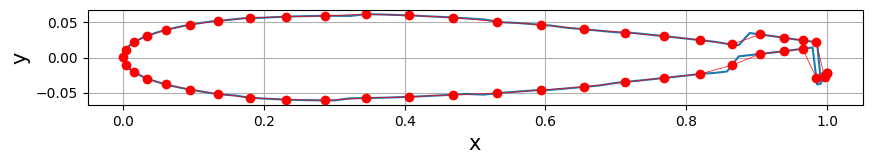

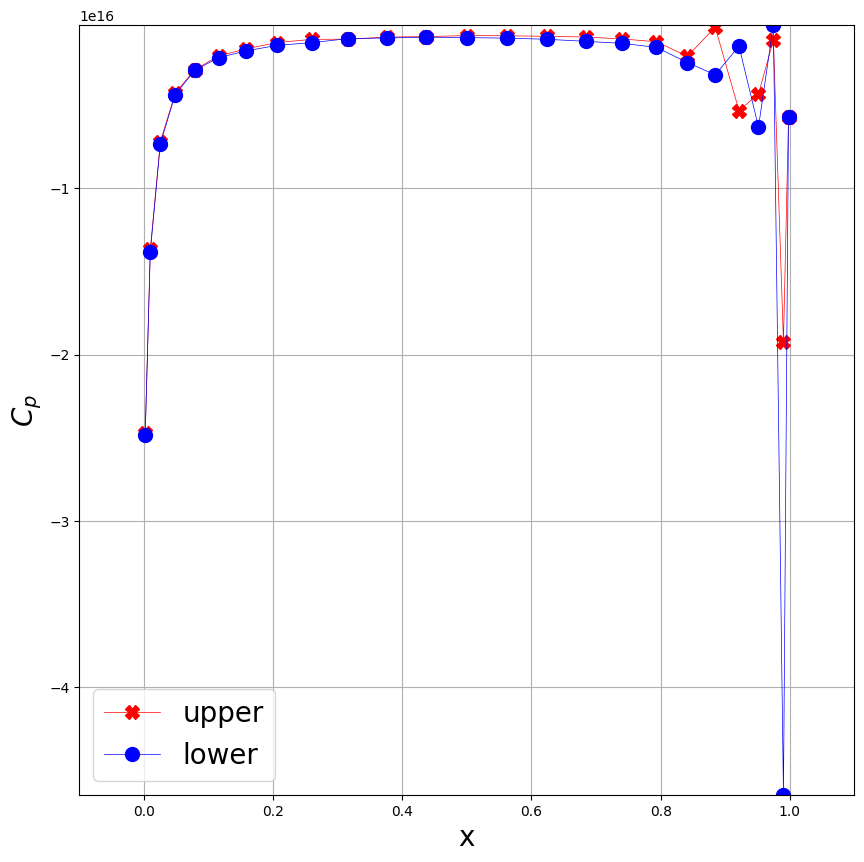

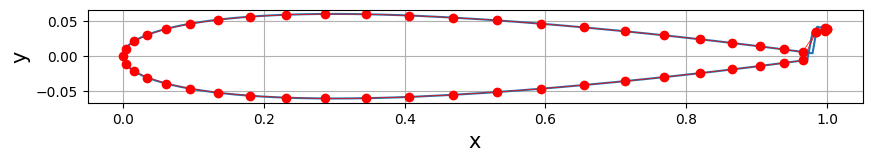

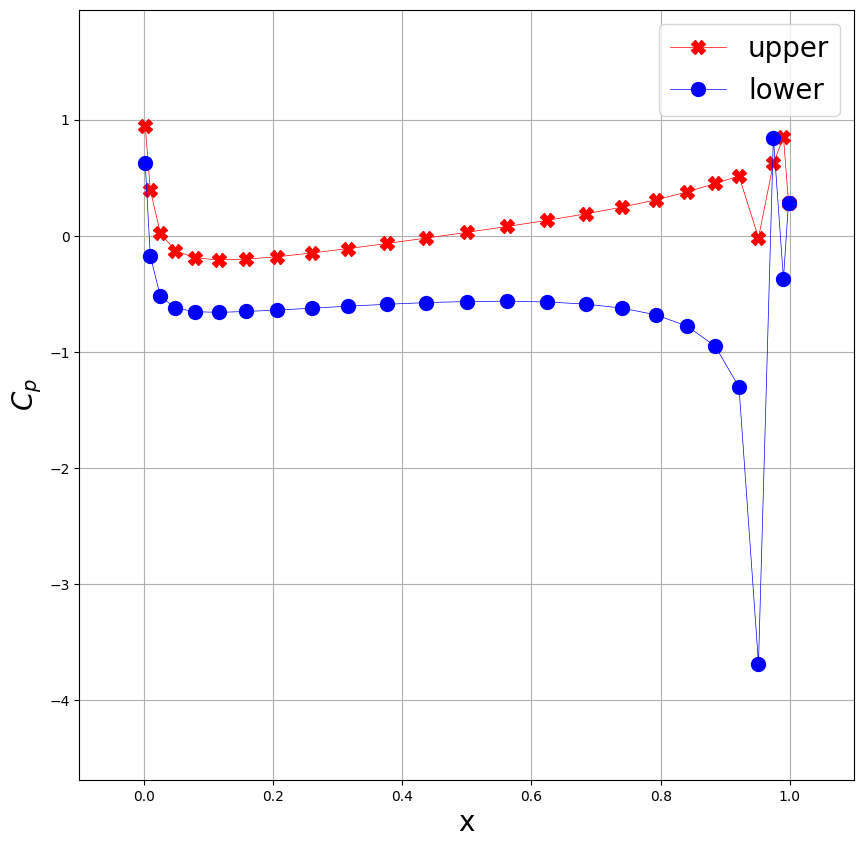

In [9]:
bests = []
worsts = []
for gen in generations:
    bests.append(max(gen, key = lambda x: x.fitness))
    worsts.append(min(gen, key = lambda x: x.fitness))
best = max(bests, key = lambda x: x.fitness)
worst = min(worsts, key = lambda x: x.fitness)
print(best.fitness, worst.fitness)
print(best.cl, worst.cl)
best.draw()
best.draw_cp()
worst.draw()
worst.draw_cp()
print(f"ID of best solution: {best.ID}")
[best.fitness for best in bests][:5]

In [10]:
with open("generations_shadow_power3_prob05", "wb") as pkl:
    pickle.dump(generations, pkl, protocol = pickle.HIGHEST_PROTOCOL)

In [2]:
with (open("generations_shadow_power3_prob05", "rb")) as pkl:
    generations = pickle.load(pkl)

In [6]:
avg_fitness = []
max_fitness = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        for p in gen:
            avg += p.fitness
            maxi = max([maxi, p.fitness])
        avg = avg / len(gen)
        avg_fitness.append((avg, i+1))
        max_fitness.append((maxi, i+1))

In [7]:
avg_fitness_smooth = []
max_fitness_smooth = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        k = 0
        for p in gen:
            if p.roughness < 3:
                avg += p.fitness
                maxi = max([maxi, p.fitness])
                k += 1
        if k != 0:
            avg = avg / k
        else:
            avg = 0
        avg_fitness_smooth.append((avg, i+1))
        max_fitness_smooth.append((maxi, i+1))

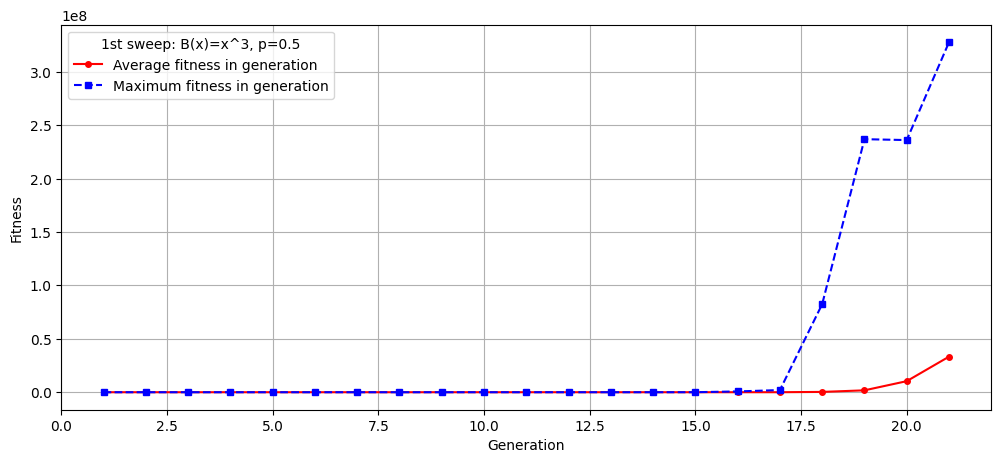

In [8]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation"],
          title = "1st sweep: B(x)=x^3, p=0.5")

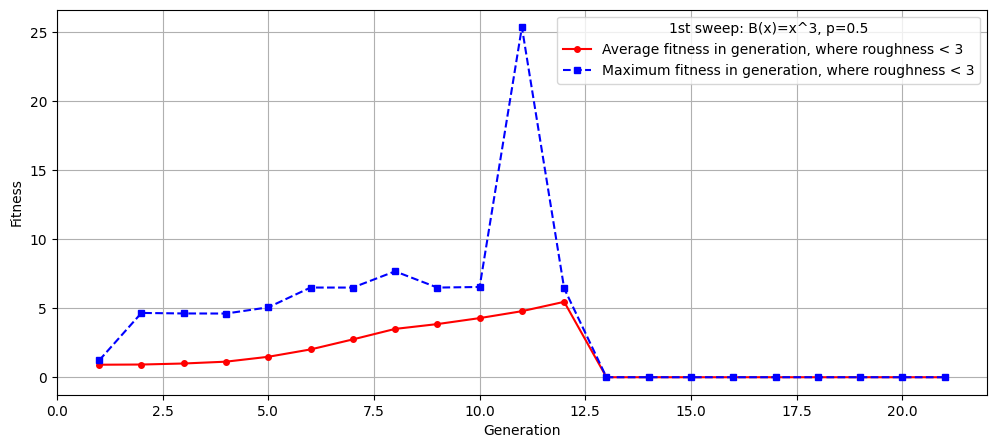

In [11]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
          title = "1st sweep: B(x)=x^3, p=0.5")

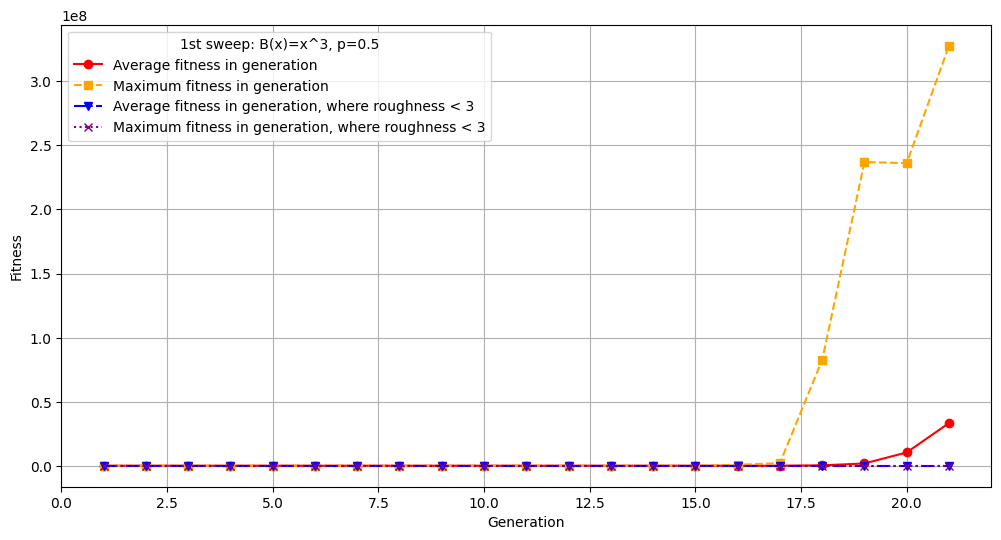

In [10]:
plt.figure(figsize=(12,6))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "6", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "orange", marker = "s", markersize = "6", linestyle = "dashed")
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "v", markersize = "6", linestyle = "dashdot")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "purple", marker = "x", markersize = "6", linestyle = "dotted")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation",
            "Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
          title = "1st sweep: B(x)=x^3, p=0.5")

In [3]:
bests = []
for gen in generations:
    bests.append(max(gen, key = lambda x: x.fitness))
best = max(bests, key = lambda x: x.fitness)

bests_constrained = []
for gen in generations:
    try:
        bests_constrained.append(max([p for p in gen if p.roughness < 3], key = lambda x: x.fitness))
    except:
        pass
best_constrained = max(bests_constrained, key = lambda x: x.fitness)

C:\Users\ejwod\AeroPython\profiles.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (width, height))


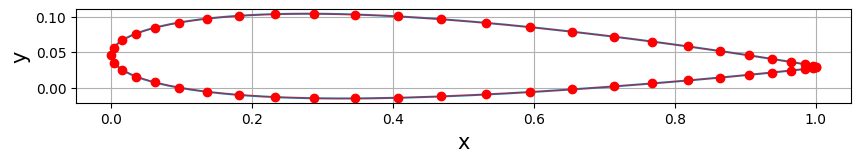

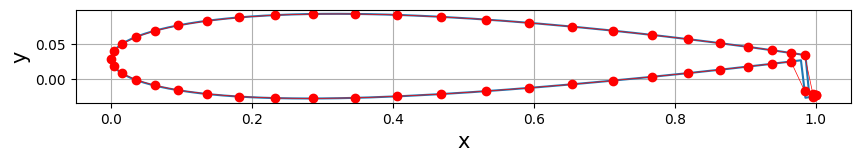

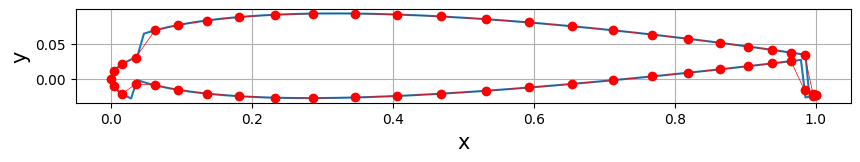

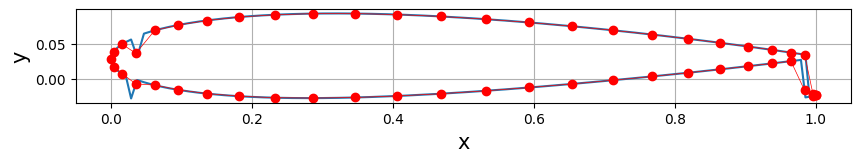

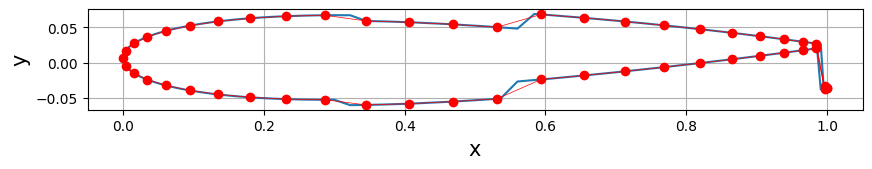

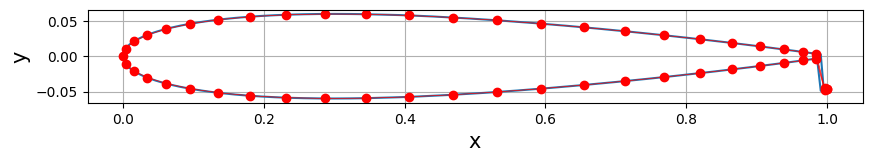

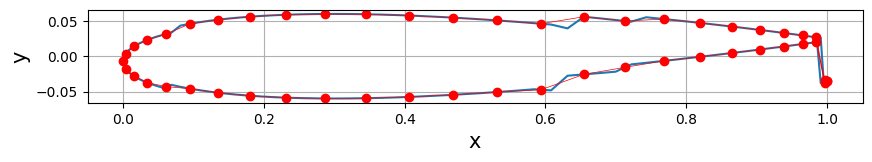

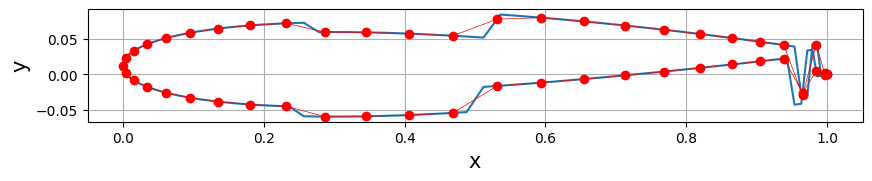

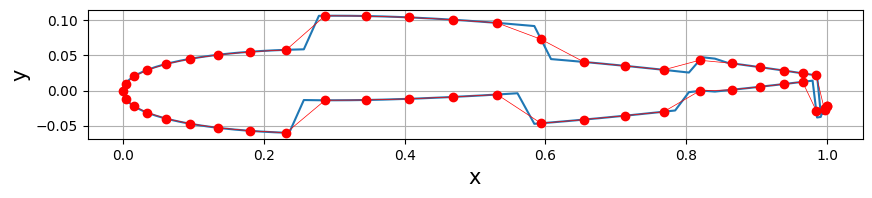

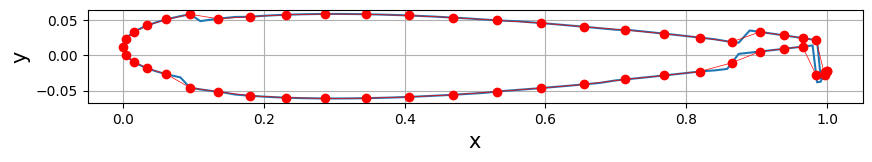

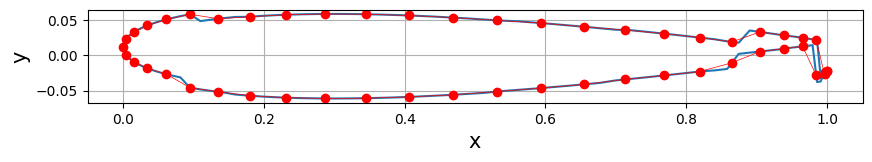

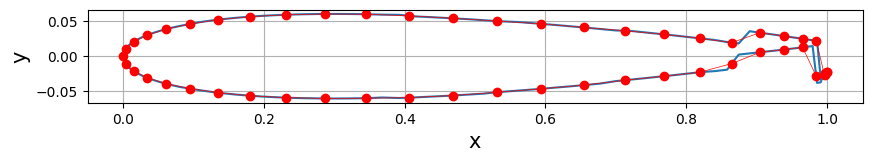

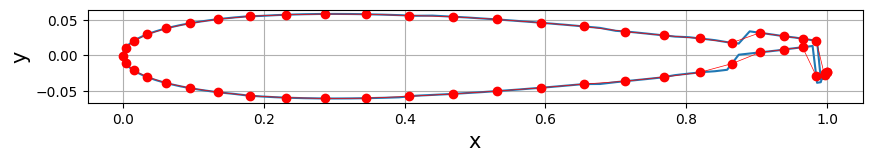

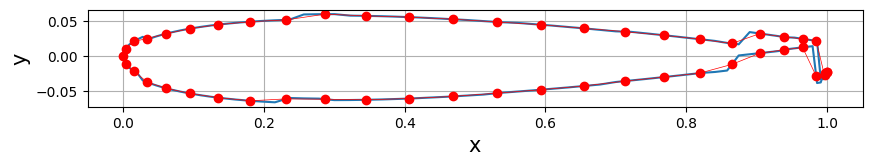

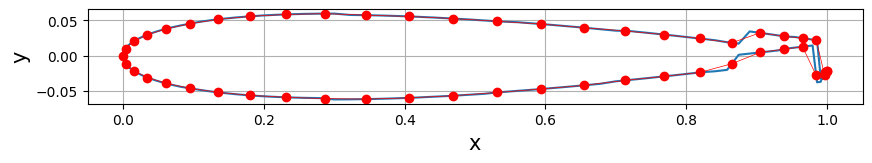

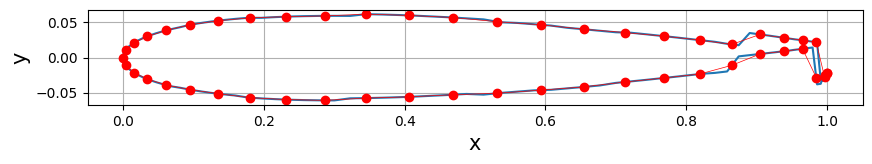

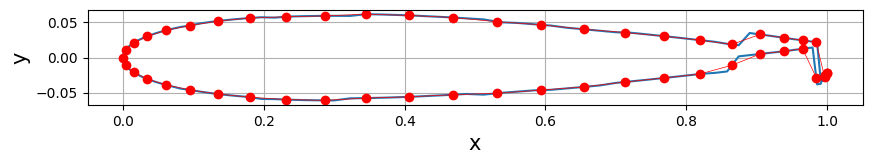

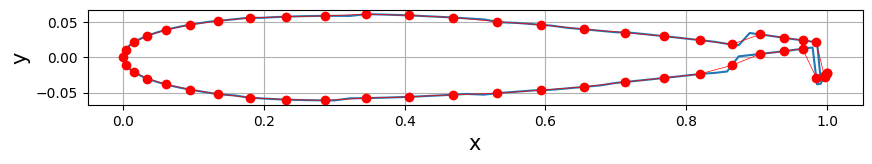

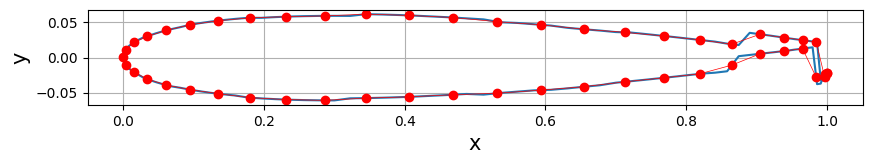

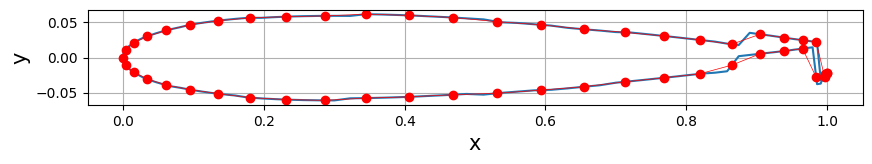

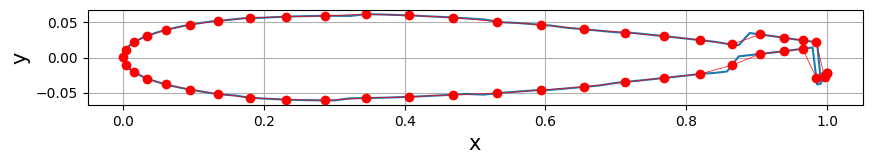

In [4]:
for p in bests:
    p.draw()

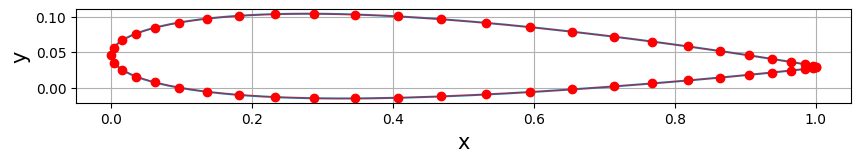

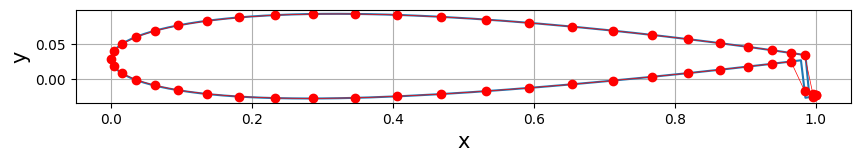

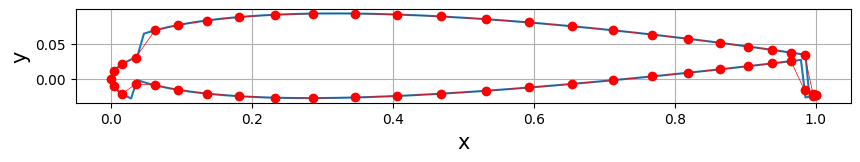

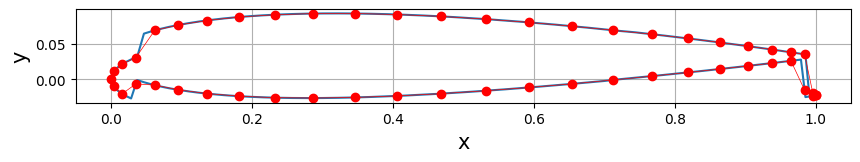

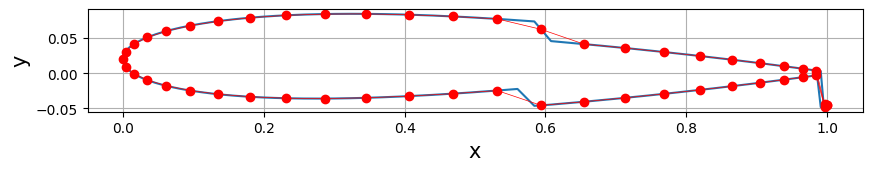

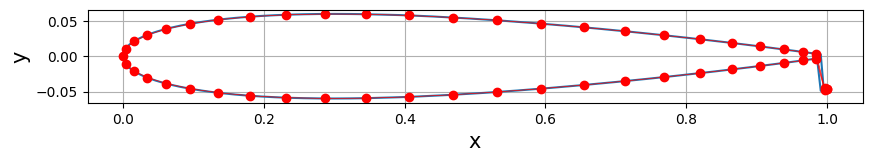

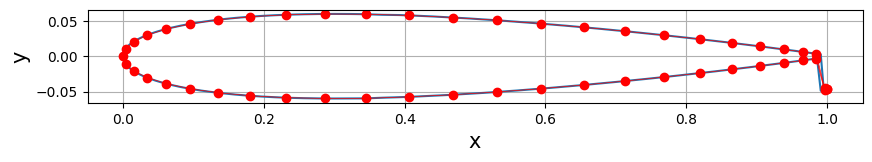

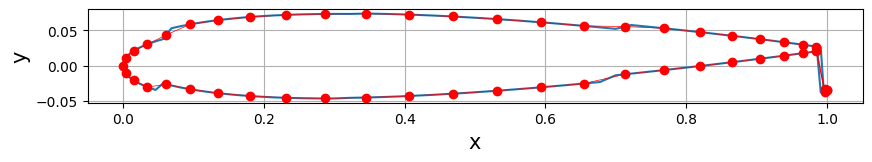

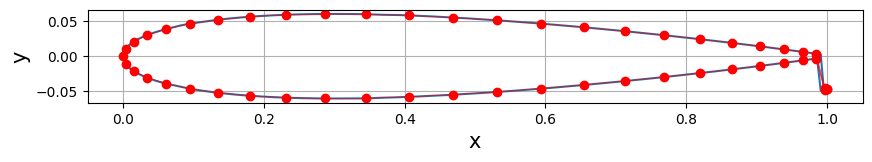

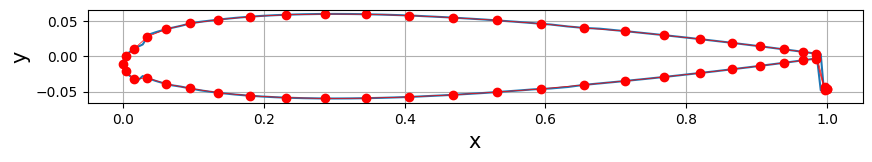

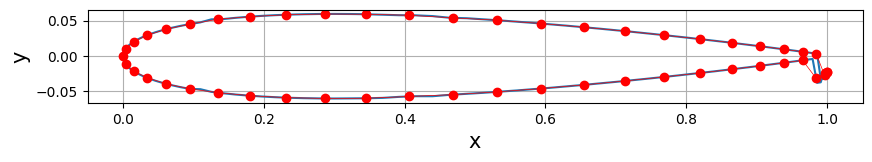

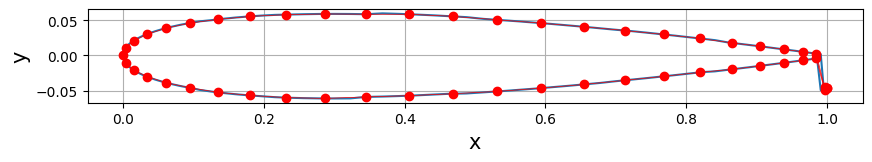

In [5]:
for p in bests_constrained:
    p.draw()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


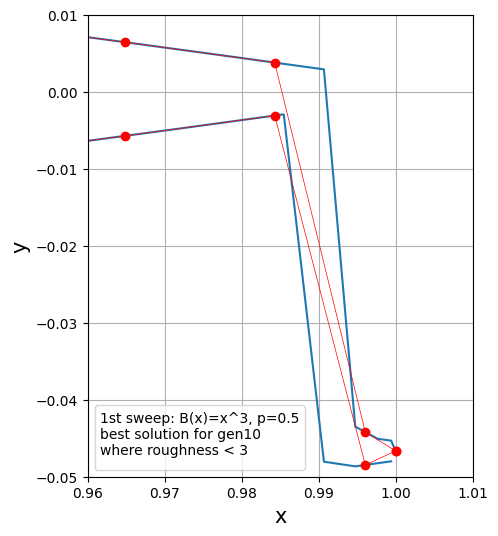

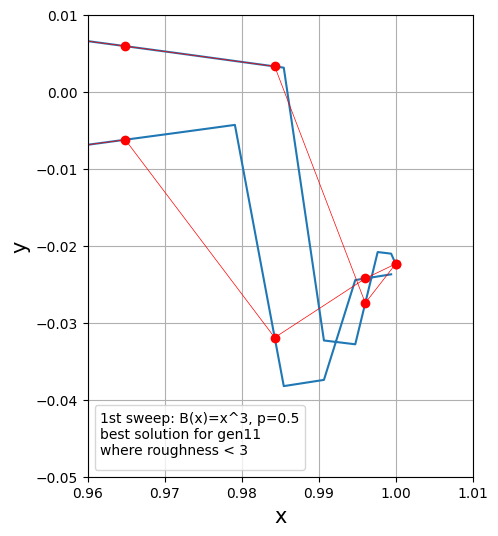

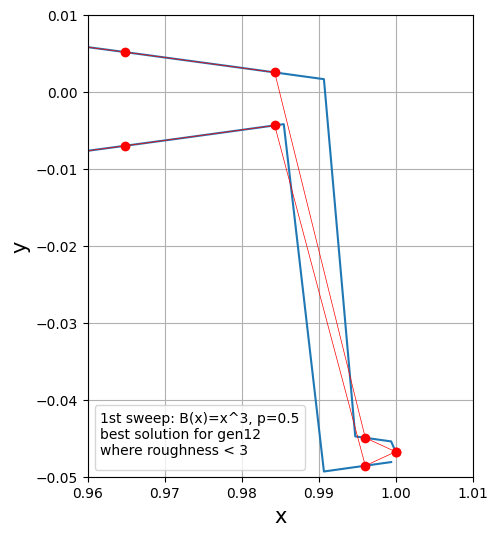

In [40]:
def custom_draw(P, description, width = 6, height = 6):
    panels = P.panels
    x = P.x
    y = P.y
    
    
    plt.figure(figsize = (width, height))
    plt.grid()
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("y", fontsize = 15)
    plt.plot(x, y)
    plt.axis("scaled")
    plt.xlim(0.96, 1.01)
    plt.ylim(-0.05, 0.01)
    plt.plot(np.append([panel.x_a for panel in panels], panels[0].x_a),
     np.append([panel.y_a for panel in panels], panels[0].y_a),
    marker = "o", color = "red", linewidth = 0.5)
    plt.legend(
          title = description)

custom_draw(bests_constrained[10-1], "1st sweep: B(x)=x^3, p=0.5\nbest solution for gen10\nwhere roughness < 3")
custom_draw(bests_constrained[11-1], "1st sweep: B(x)=x^3, p=0.5\nbest solution for gen11\nwhere roughness < 3")
custom_draw(bests_constrained[12-1], "1st sweep: B(x)=x^3, p=0.5\nbest solution for gen12\nwhere roughness < 3")